In [2]:
!pip install efficientnet-pytorch
!pip install timm
!pip install -U albumentations
import os
import torch
import shutil
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import timm as tm
import random
from torch.utils.data import Dataset, random_split, DataLoader, SubsetRandomSampler
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import albumentations
from albumentations import pytorch as AT
from efficientnet_pytorch import EfficientNet
import copy
import tqdm
import time
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from google.colab.patches import cv2_imshow
%matplotlib inline

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=d990c7aaaeb1a10e1620dd51c7a77964d4b41eaf10fc9d6184993978825c67d1
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch
     |████████████████████████████████| 296kB 17.3MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 37.6MB 74kB/s 
     |████████████████████████████████| 952kB 51.9MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
labels = {
    0: 'badminton',
    1: 'baseball',
    2: 'basketball',
    3: 'boxing',
    4: 'chess',
    5: 'cricket',
    6: 'fencing',
    7: 'football',
    8: 'formula1',
    9: 'gymnastics',
    10: 'hockey',
    11: 'ice_hockey',
    12: 'kabaddi',
    13: 'motogp',
    14: 'shooting',
    15: 'swimming',
    16: 'table_tennis',
    17: 'tennis',
    18: 'volleyball',
    19: 'weight_lifting',
    20: 'wrestling',
    21: 'wwe'
}

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
with zipfile.ZipFile('/content/drive/MyDrive/train.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [9]:
DATA_DIR = '/content'
DATA_CSV = '/content/train_labels.csv'

In [10]:
data_df = pd.read_csv(DATA_CSV)
data_df.head(5)

,image,sports
0,./train/0.jpg,baseball
1,./train/1.jpg,formula1
2,./train/2.jpg,fencing
3,./train/3.jpg,motogp
4,./train/4.jpg,ice_hockey


In [11]:
len(data_df['sports'].unique())

22

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


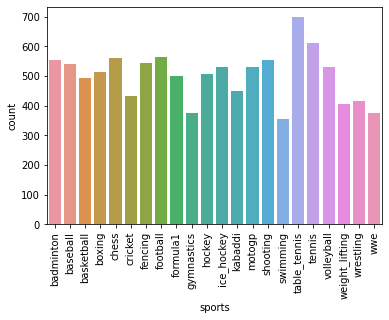

In [12]:
ax = sns.countplot(
    data_df['sports'],
    
)
ax.set_xticklabels(labels.values(), rotation=90);

In [13]:
def conv_str_int(st):
    conv = {
    'badminton': 0,
    'baseball' : 1,
    'basketball': 2,
    'boxing': 3,
    'chess': 4,
    'cricket': 5,
    'fencing': 6,
    'football': 7,
    'formula1' : 8,
    'gymnastics': 9,
    'hockey': 10,
    'ice_hockey': 11,
    'kabaddi': 12,
    'motogp': 13,
    'shooting': 14,
    'swimming': 15,
    'table_tennis': 16,
    'tennis': 17,
    'volleyball': 18,
    'weight_lifting': 19,
    'wrestling': 20,
    'wwe': 21
    }
    return conv[st]

In [14]:
class SportsImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image'], row['sports']
        img_fname = self.root_dir + "/" + img_id.split('/')[-2] + "/" + img_id.split('/')[-1]
        img = cv2.imread(img_fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']
        return image, conv_str_int(img_label)

In [15]:
def seedeverything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seedeverything(69)

In [16]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.7, frac_val=0.15, frac_test=0.15,
                                         random_state=None):
    X = df_input 
    y = df_input[[stratify_colname]] 

    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

#train_df, val_df, test_df = np.split(data_df.sample(frac=1), [int(.8*len(data_df)), int(.9*len(data_df))])
train_df, val_df, test_df = split_stratified_into_train_val_test(data_df, 'sports')

len(train_df), len(val_df), len(test_df)

(7727, 1656, 1657)

In [17]:
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [18]:
image_size = 224
data_transforms = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    #albumentations.CoarseDropout(always_apply=False, p=1.0, max_holes=10, max_height=8, max_width=8, min_holes=8, min_height=8, min_width=8),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
    AT.ToTensorV2()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(),
    albumentations.RandomRotate90(),
    albumentations.Normalize(),
    AT.ToTensorV2()
    ])

In [19]:
train_ds = SportsImageDataset(train_df, DATA_DIR, transform=data_transforms)
val_ds = SportsImageDataset(val_df, DATA_DIR, transform=data_transforms)
test_ds = SportsImageDataset(test_df, DATA_DIR, transform=data_transforms_test)

In [20]:
batch_size = 16

In [21]:
train_sampler = SubsetRandomSampler(list(train_df.index)) 
valid_sampler = SubsetRandomSampler(list(val_df.index))

In [22]:
train_loader = DataLoader(train_ds, batch_size,sampler = train_sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, sampler = valid_sampler, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
def show(img, target):
    
    input_tensor = img
    input_tensor = input_tensor.to(torch.device('cpu'))
    input_tensor = input_tensor.squeeze()
    input_tensor = input_tensor.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).type(torch.uint8).numpy()
    #input_tensor = cv2.cvtColor(input_tensor, cv2.COLOR_RGB2BGR)
    
    plt.imshow(input_tensor)
    plt.show()
    print(labels[target])

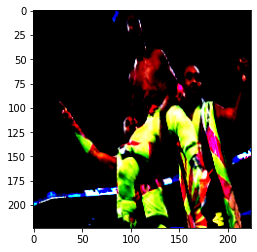

wwe


In [24]:
show(*train_ds[154])


In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [27]:
class SportsImageLinearModel(ImageClassificationBase):
    def __init__(self, output_size):
        super().__init__()

        #self.network = models.resnet101(pretrained=True, progress=True)
        self.network = tm.create_model('efficientnet_b3a', pretrained=True, num_classes=output_size)
        #self.network = EfficientNet.from_pretrained('efficientnet-b7')

        #num_ftrs = self.network.fc.in_features
        #self.network.fc = nn.Linear(num_ftrs, output_size)
        #self.network.classifier[6] = nn.Linear(4096, output_size)
        #feature = self.network._fc.in_features
        #self.network._fc = nn.Linear(in_features=feature,out_features=output_size,bias=True)

    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad = False
        
        for param in self.network.fc.parameters():
            param.require_grad = True
            
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad = True

In [28]:
input_size = 3*224*224
output_size = 22

In [29]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [33]:
device = get_default_device()
device

device(type='cuda')

In [34]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
model = to_device(SportsImageLinearModel(output_size), device)

In [35]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, betas=(0.9, 0.999), weight_decay=weight_decay, amsgrad=False)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                               steps_per_epoch=len(train_loader))
    #sched = torch.optim.lr_scheduler.CyclicLR(optimizer, 0.001, max_lr=max_lr, mode='triangular2', )
    #sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1,)
    #sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
    
    

    for epoch in range(epochs):
        model.train()
        train_losses = []
        val_loss = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            val_loss.append(loss.item()) 
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation 
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        #sched.step(torch.stack(train_losses).mean().item())
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [36]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.044070515781641006, 'val_loss': 3.112853527069092}]

In [37]:
epochs = 15
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [38]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 3.0506, val_loss: 2.9481, val_acc: 0.1667
Epoch [1], train_loss: 2.7802, val_loss: 2.6309, val_acc: 0.5968
Epoch [2], train_loss: 2.4716, val_loss: 2.3891, val_acc: 0.7915
Epoch [3], train_loss: 2.3277, val_loss: 2.3084, val_acc: 0.8409
Epoch [4], train_loss: 2.2670, val_loss: 2.2744, val_acc: 0.8800
Epoch [5], train_loss: 2.2365, val_loss: 2.2619, val_acc: 0.8858
Epoch [6], train_loss: 2.2168, val_loss: 2.2611, val_acc: 0.8926
Epoch [7], train_loss: 2.2060, val_loss: 2.2548, val_acc: 0.8974
Epoch [8], train_loss: 2.2010, val_loss: 2.2575, val_acc: 0.8978
Epoch [9], train_loss: 2.1939, val_loss: 2.2481, val_acc: 0.9077
Epoch [10], train_loss: 2.1889, val_loss: 2.2530, val_acc: 0.8992
Epoch [11], train_loss: 2.1868, val_loss: 2.2499, val_acc: 0.9069
Epoch [12], train_loss: 2.1856, val_loss: 2.2514, val_acc: 0.9091
Epoch [13], train_loss: 2.1832, val_loss: 2.2513, val_acc: 0.9069
Epoch [14], train_loss: 2.1832, val_loss: 2.2513, val_acc: 0.9103
CPU times: user 17mi

In [39]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

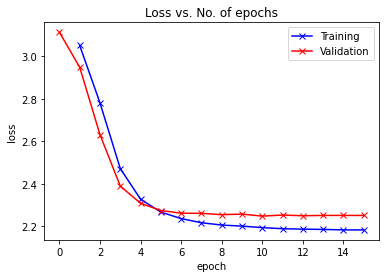

In [40]:
plot_losses(history)

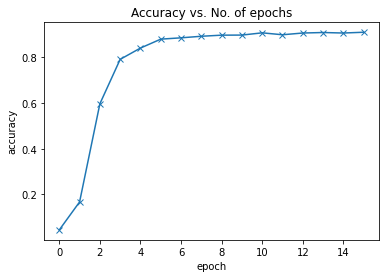

In [41]:
plot_accuracies(history)

In [42]:
test_loader = DeviceDataLoader(test_loader, device)
eval_test = evaluate(model, test_loader)
eval_test

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.8106250166893005, 'val_loss': 2.331582546234131}

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    _, preds = torch.max(prediction, dim=0)
    show(image, preds.item())

Prediction:  tensor([1.3804e-05, 4.0693e-05, 7.6691e-05, 2.9555e-01, 1.1315e-03, 2.9426e-04,
        1.2103e-04, 7.2471e-05, 1.7624e-01, 1.6154e-05, 7.1494e-05, 3.7242e-03,
        4.2721e-02, 2.9596e-05, 4.8430e-04, 7.6464e-04, 3.8820e-04, 7.3554e-05,
        1.1472e-04, 9.9979e-01, 3.7371e-03, 3.5493e-03], device='cuda:0',
       grad_fn=<SelectBackward>)


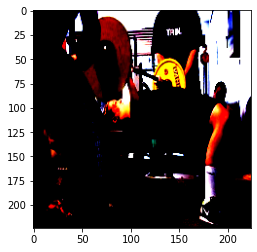

weight_lifting


In [ ]:
predict_single(test_ds[328][0])

In [44]:
model.cpu()
torch.save(model.network.state_dict(), 'efficientnet_b3a_85.pt')

In [ ]:
def CheckCustomImage(path):
    pil2tensor = transforms.ToTensor()
    xb = Image.open(path)
    xb = xb.resize((224, 224))
    b, g, r = xb.split()
    xb = Image.merge("RGB", (r, g, b))
    xb = pil2tensor(xb)
    #xb = to_device(xb, device)
    model.cpu();
    preds = model(xb.reshape(1, 3, 224, 224))
    prediction = preds[0].cpu()
    #prediction.cpu()
    print("Prediction: ", prediction)
    _, preds = torch.max(prediction, dim=0)
    show_sample(xb, preds.item(), prediction=False, invert=False)

Prediction:  tensor([0.9998, 0.0159, 0.0949, 0.0250, 0.3709, 0.0034, 0.9999, 0.4057, 0.9972,
        0.9527, 0.0689, 0.7324, 0.3479, 0.1314, 0.7447, 0.3138, 1.0000, 0.0113,
        0.1062, 0.9939, 0.0024, 0.0128], grad_fn=<SelectBackward>)
torch.Size([3, 224, 224])
Label (numeric): 16
Label: table_tennis


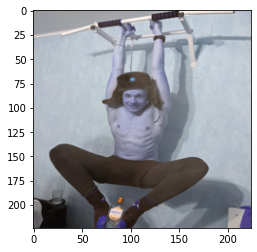

In [ ]:
CheckCustomImage('/content/t5.jpg')

In [43]:
def TestAccuracy(model):
  total = 0
  correct = 0
  accuracy = 0
  model = to_device(model, device)
  with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        #images, labels = images.cuda(), labels.cuda()
        images = to_device(images, device)
        labels = to_device(labels, device)
        outputs = model(images)
        predicted = torch.max(outputs.data, 1)[1]
        total += len(labels)    
        correct += (predicted == labels).sum()
                
  accuracy = 100 * correct / float(total)
  return accuracy

TestAccuracy(model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(82.5588, device='cuda:0')

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/test.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [ ]:
def infer(path_to_model, path_to_images):
    model_s = torch.load(path_to_model)
    model.load_state_dict(model_s)

    pil2tensor = transforms.ToTensor()
    images = []
    predictions = []
    index = []
    i = 0
    for filename in os.listdir(path_to_images):
        img = Image.open(path_to_images + '/' + filename)
        xb = img 
        xb =  xb.resize((224, 224))
        xb = pil2tensor(xb)
        xb = to_device(xb, device)
        preds = model(xb.reshape(1, 3, 224, 224))
        prediction = preds[0]
        _, preds = torch.max(prediction, dim=0)
        preds.cpu()
        label = labels[preds.item()]
        images.append(filename)
        index.append( int(filename.split('.')[0]) )
        predictions.append(label)
    output = pd.DataFrame(data={"index":index,"image":images,"label":predictions})
    sorted_df = output.sort_values(by=["index"], ascending=True) 
    sorted_df = sorted_df.drop(columns="index")
    sorted_df.to_csv(path_or_buf="submission.csv", index=False, quoting=3)

infer('/content/E_Net_84.pt', '/content/test')